[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sunyeul/playground/blob/main/Interval_estimator/Random_Forest_predict_std.ipynb)

In [182]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.model_selection import train_test_split

from dataclasses import dataclass
from typing import List, Dict, Callable
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

In [2]:
@dataclass(frozen=True)
class LeafNode:
    node_size: int
    mean_feature_vector: np.ndarray
    mean_target_value: float
    std_target_value: float

def fit_leaf_nodes(
    self,
    X: pd.DataFrame,
    y: pd.Series
):

    self.leaf_nodes_ = []

    for estimator in self.estimators_:
        leaf_nos = estimator.apply(X.to_numpy())

        leaf_nodes = {}
        for leaf_no in np.unique(leaf_nos):
            leaf_node_size = np.sum(leaf_nos == leaf_no)
            mean_feature_vector = X[leaf_nos == leaf_no].mean().to_numpy()
            mean_target_value = y[leaf_nos == leaf_no].mean()
            std_target_value = y[leaf_nos == leaf_no].std()

            leaf_nodes[leaf_no] = LeafNode(
                node_size=leaf_node_size, 
                mean_feature_vector=mean_feature_vector,
                mean_target_value=mean_target_value,
                std_target_value=std_target_value
            )

        self.leaf_nodes_.append(leaf_nodes)

RandomForestRegressor.fit_leaf_nodes = fit_leaf_nodes

In [38]:
def predict_knowledge_uncertainty(self, X: pd.DataFrame) -> np.ndarray:
    predict_matrix = []

    for i, estimator in enumerate(self.estimators_):
        predict_matrix.append(
            estimator.predict(X.to_numpy())
        )

    knowledge_uncertainty = np.std(np.array(predict_matrix), axis=0)
    return knowledge_uncertainty

RandomForestRegressor.predict_knowledge_uncertainty = predict_knowledge_uncertainty

In [39]:
def predict_data_uncertainty(self, X: pd.DataFrame) -> np.ndarray:
    std_matrix = []

    for i, (estimator, leaf_node) in enumerate(zip(self.estimators_, self.leaf_nodes_)):
        leaf_nos = estimator.apply(X.to_numpy())

        std_target_values = np.array([leaf_node[leaf_no].std_target_value for leaf_no in leaf_nos])
        std_matrix.append(std_target_values)

    data_uncertainty = np.mean(np.array(std_matrix), axis=0)

    return data_uncertainty

RandomForestRegressor.predict_data_uncertainty = predict_data_uncertainty

In [51]:
def calc_bias(y_true, y_pred):
    return np.mean(y_true - y_pred)

In [204]:
X, y = load_diabetes(
    return_X_y=True,
    as_frame=True
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=.8,
    test_size=.2,
    shuffle=True,
    stratify=pd.cut(y, bins=5),
    random_state=3407
)

In [205]:
rf = RandomForestRegressor(
    n_estimators=1_000,
    max_depth=3,
    min_samples_leaf=10,
    random_state=3407,
    n_jobs=-1
)

rf.fit(
    X=X_train,
    y=y_train
)

rf.fit_leaf_nodes(
    X=X_train,
    y=y_train
)

In [206]:
clf = RandomForestClassifier(
    n_estimators=1_000,
    max_depth=3,
    min_samples_leaf=10,
    random_state=3407,
    n_jobs=-1
)

clf.fit(
    X=pd.concat([X_train, X_test], axis=0),
    y=np.array([0 for _ in range(len(X_train))] + [1 for _ in range(len(X_test))])
)

RandomForestClassifier(max_depth=3, min_samples_leaf=10, n_estimators=1000,
                       n_jobs=-1, random_state=3407)

In [207]:
train_pred_df = pd.DataFrame(
    data={
        "y_true": y_train,
        "y_pred": rf.predict(X_train),
        "adversarial_score": clf.predict_proba(X_train)[:, 1],
        "data_uncertainty": rf.predict_data_uncertainty(X_train),
        "knowledge_uncertainty": rf.predict_knowledge_uncertainty(X_train)
    }
)

train_pred_df["total_uncertainty"] = train_pred_df.eval("data_uncertainty + knowledge_uncertainty")
train_pred_df["normalization"] = train_pred_df.eval("(y_true - y_pred) / total_uncertainty")
train_pred_df["normal_pdf"] = train_pred_df["normalization"].apply(scipy.stats.norm(0, 1).pdf)
train_pred_df["mae"] = train_pred_df.eval("abs(y_true - y_pred)")


test_pred_df = pd.DataFrame(
    data={
        "y_true": y_test,
        "y_pred": rf.predict(X_test),
        "adversarial_score": clf.predict_proba(X_test)[:, 1],
        "data_uncertainty": rf.predict_data_uncertainty(X_test),
        "knowledge_uncertainty": rf.predict_knowledge_uncertainty(X_test)
    }
)

test_pred_df["total_uncertainty"] = test_pred_df.eval("data_uncertainty + knowledge_uncertainty")
test_pred_df["normalization"] = test_pred_df.eval("(y_true - y_pred) / total_uncertainty")
test_pred_df["normal_pdf"] = test_pred_df["normalization"].apply(scipy.stats.norm(0, 1).pdf)
test_pred_df["mae"] = test_pred_df.eval("abs(y_true - y_pred)")

In [208]:
train_pred_df.describe()

,y_true,y_pred,adversarial_score,data_uncertainty,knowledge_uncertainty,total_uncertainty,normalization,normal_pdf,mae
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,151.864023,151.780161,0.191393,53.787408,24.247916,78.035324,-0.008542,0.338443,39.757048
std,76.977038,52.699082,0.033133,7.927246,9.317704,16.493478,0.608946,0.060324,28.174297
min,25.000000,83.815024,0.130755,40.602283,9.175964,50.810918,-1.360841,0.108629,0.179984
25%,86.000000,100.125935,0.168186,45.912389,14.533821,61.097803,-0.545969,0.307857,17.412767
50%,139.000000,149.393336,0.184419,55.613585,24.953247,82.638986,-0.041619,0.351134,38.273157
75%,214.000000,189.698370,0.206269,60.535759,29.975776,89.424616,0.426142,0.388543,55.163540
max,346.000000,270.674401,0.333482,69.899993,51.326002,112.370208,1.612995,0.398941,131.629187


In [209]:
test_pred_df.iloc[test_pred_df["mae"].argmax()]

y_true                   302.000000
y_pred                   149.277067
adversarial_score          0.166116
data_uncertainty          56.807840
knowledge_uncertainty     28.229642
total_uncertainty         85.037483
normalization              1.795948
normal_pdf                 0.079527
mae                      152.722933
Name: 102, dtype: float64

In [222]:
test_pred_df.iloc[test_pred_df["total_uncertainty"].argmax()]

y_true                   131.000000
y_pred                   185.167954
adversarial_score          0.198899
data_uncertainty          68.633742
knowledge_uncertainty     43.786236
total_uncertainty        112.419979
normalization             -0.481836
normal_pdf                 0.355219
mae                       54.167954
Name: 163, dtype: float64

In [223]:
test_pred_df.iloc[test_pred_df["adversarial_score"].argmax()]

y_true                   55.000000
y_pred                   92.102987
adversarial_score         0.362166
data_uncertainty         44.224624
knowledge_uncertainty    12.517613
total_uncertainty        56.742236
normalization            -0.653887
normal_pdf                0.322155
mae                      37.102987
Name: 41, dtype: float64

In [221]:
test_pred_df.describe()

,y_true,y_pred,adversarial_score,data_uncertainty,knowledge_uncertainty,total_uncertainty,normalization,normal_pdf,mae
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,153.202247,151.645638,0.241515,54.128513,24.631745,78.760258,0.026752,0.309353,51.752360
std,77.980064,51.324381,0.045887,7.938508,9.578718,16.916176,0.797128,0.087762,36.327040
min,31.000000,84.913208,0.158283,40.875892,9.658159,51.304603,-1.524316,0.060659,1.278547
25%,89.000000,100.711934,0.206368,46.687356,15.012219,60.988262,-0.529087,0.263879,21.711934
50%,143.000000,150.967157,0.230170,56.449322,26.048155,84.793976,-0.185777,0.337408,44.158786
75%,202.000000,197.289704,0.278916,60.533222,29.902146,89.973823,0.629109,0.377658,70.542963
max,332.000000,268.421881,0.362166,69.018581,49.094762,112.419979,1.940902,0.398824,152.722933


In [211]:
calc_bias(y_true=y_test, y_pred=rf.predict(X_test))

1.5566089012827324

In [212]:
mean_absolute_error(y_test, rf.predict(X_test))

51.75235956685495

In [213]:
mean_squared_error(y_test, rf.predict(X_test))

3983.1329658121203

In [214]:
mean_absolute_percentage_error(y_test, rf.predict(X_test))

0.4392712108260238

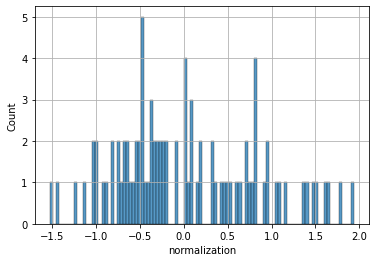

In [215]:
sns.histplot(
    data=test_pred_df,
    x="normalization",
    bins=100
)

plt.grid(True)
plt.show()

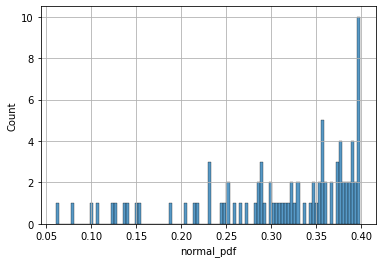

In [216]:
sns.histplot(
    data=test_pred_df,
    x="normal_pdf",
    bins=100
)

plt.grid(True)
plt.show()

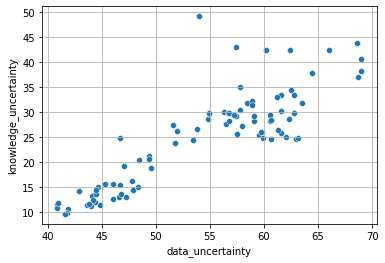

In [217]:
sns.scatterplot(
    data=test_pred_df,
    x="data_uncertainty",
    y="knowledge_uncertainty",
)

plt.grid(True)
plt.show()

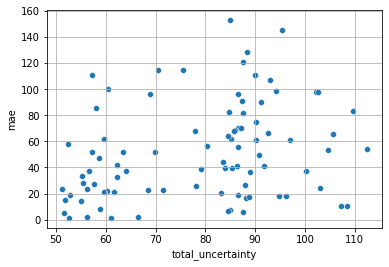

In [218]:
sns.scatterplot(
    data=test_pred_df,
    x="total_uncertainty",
    y="mae",
)

plt.grid(True)
plt.show()

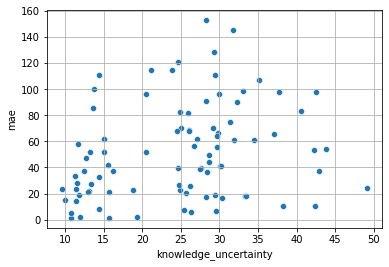

In [219]:
sns.scatterplot(
    data=test_pred_df,
    x="knowledge_uncertainty",
    y="mae",
)

plt.grid(True)
plt.show()

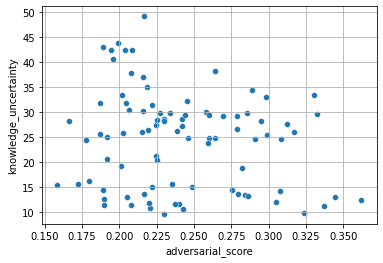

In [220]:
sns.scatterplot(
    data=test_pred_df,
    x="adversarial_score",
    y="knowledge_uncertainty",
)

plt.grid(True)
plt.show()